In [71]:
#supress warnings (especially from sklearn)
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, LeaveOneOut
from sklearn.linear_model import ElasticNetCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, average_precision_score, precision_recall_curve, roc_curve, auc, precision_score, roc_curve, confusion_matrix
from sklearn.decomposition import PCA
import seaborn as sns
import csv
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
from scipy import interp
from sklearn.metrics import roc_auc_score

%matplotlib inline

In [20]:
def all_patient_preprocess(): 
    data = pd.read_csv('../data/labeled_clustered_data.csv')
    df_0 = data.drop(['Unnamed: 0', 'Unnamed: 0_y', 'cluster_num', 'sapsii', 'sofa'], axis=1)
    df_0_label=df_0.pop('label')
    return [df_0], [df_0_label]

In [83]:
def create_pipeline():
    pipeline = []
    lr = LogisticRegressionCV(random_state = 0, n_jobs=-1)
    en = ElasticNetCV(random_state = 0, n_jobs=-1)
    rf = RandomForestClassifier(random_state=0, n_jobs=-1)
    xgb_roc = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=9, missing=None, n_estimators=100, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0.25, reg_lambda=1, scale_pos_weight=8.286036036036036,
              seed=1, silent=None, subsample=0.8, verbosity=1)
    xgb_spec = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.2, gamma=0.0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=110, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=8.286036036036036,
              seed=1, silent=None, subsample=0.9, verbosity=1)
    pipeline.append(['logistic_regression', lr]) 
    pipeline.append(['random_forest', rf])
    pipeline.append(['xgboost', xgb_roc])
#     pipeline.append(['xgboost_spec', xgb_spec])
    return pipeline

In [22]:
def pr_curve(pr_map, dimension_reduction=False):
    for cluster, clf_map in pr_map.items():
        fig=plt.figure()
        if dimension_reduction:
            plt.title('PR Curve for Cluster '+str(cluster))
            filepath = 'results/figures/'+str(cluster)+'cluster_PR.png'
        else:
            plt.title('PR Curve for Cluster All')
            filepath = 'results/figures/cluster_all_PR.png'
        for name, values in clf_map.items():
                average_precision = values[0]
                precision = values[1]
                recall = values[2]
                plt.plot(recall, precision, label=name+' (area = {:.3f})'.format(average_precision))
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc='best')
        plt.show()
        fig.savefig(filepath)
        plt.close()

In [23]:
def run_xgboost(optimize=True):
    dfs, dfs_labels = all_patient_preprocess()
    filepath = 'results/figures/'
    for cluster, x_df in enumerate(dfs):
        y_df = dfs_labels[cluster]  
        xg_opt = opt_xgboost(cluster, x_df, y_df, optimize)
        K = 5
        eval_size = int(np.round(1./K))
        skf = StratifiedKFold(n_splits=K)
        fig = plt.figure(figsize=(7,7))
        mean_tpr = 0.0
        mean_fpr = np.linspace(0, 1, 100)
        lw = 2
        i = 0
        roc_aucs_xgbopt = []
        for train_indices, test_indices in skf.split(x_df, y_df):
            X_train, y_train = x_df.iloc[train_indices], y_df.iloc[train_indices]
            X_valid, y_valid = x_df.iloc[test_indices], y_df.iloc[test_indices]
            class_weight_scale = 1.*y_train.value_counts()[0]/y_train.value_counts()[1]
            print('class weight scale : {}'.format(class_weight_scale))
            xgb_opt.set_params(**{'scale_pos_weight' : class_weight_scale})
            xgb_opt.fit(X_train,y_train)
            xgb_opt_pred_prob = xgb_opt.predict_proba(X_valid)
            fpr, tpr, thresholds = precision_recall_curve(y_valid, xgb_opt_pred_prob[:, 1])
            mean_tpr += interp(mean_fpr, fpr, tpr)
            mean_tpr[0] = 0.0
            roc_auc = average_precision_score(y_valid, xgb1_pred_prob[:, 1])
            roc_aucs_xgbopt.append(roc_auc)
            plt.plot(fpr, tpr, lw=2, label='PR fold %d (area = %0.2f)' % (i, roc_auc))

            i += 1

            plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
                     label='Luck')

            mean_tpr /= K
            mean_tpr[-1] = 1.0
            mean_auc = auc(mean_fpr, mean_tpr)
            plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
                     label='Mean PR (area = %0.2f)' % mean_auc, lw=lw)

            plt.xlim([-0.05, 1.05])
            plt.ylim([-0.05, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('PR curve Cluster %d' % (cluster))
            plt.legend(loc="lower right")

            fig.savefig(filepath+'PR_Curve_cluster_'+str(cluster)+'.png')
            if optimize:

                aucs = [np.mean(roc_aucs_xgb1),
                        gsearch0.best_score_,
                        gsearch1.best_score_,
                        gsearch2.best_score_,
                        gsearch3.best_score_,
                        gsearch4.best_score_,
                        np.mean(roc_aucs_xgbopt)]

                fig = plt.figure(figsize=(4,4))
                plt.scatter(np.arange(1,len(aucs)+1), aucs)
                plt.plot(np.arange(1,len(aucs)+1), aucs)
                plt.xlim([0.5, len(aucs)+0.5])
                plt.ylim([0.99*aucs[0], 1.01*aucs[-1]])
                plt.xlabel('Hyperparamter optimization step')
                plt.ylabel('AUC')
                plt.title('Hyperparameter optimization')
                plt.grid()
                fig.savefig(filepath+'_optimization_cluster_'+str(cluster)+'.png')
        


def opt_xgboost(cluster, x_df, y_df, optimize=True):
    # Define the class weight scale (a hyperparameter) as the ration of negative labels to positive labels.
    # This instructs the classifier to address the class imbalance.
    class_weight_scale = 1.*y_df.value_counts()[0]/y_df.value_counts()[1]
    filepath = 'results/figures/'
    # Setting minimal required initial hyperparameters
    param={
        'objective':'binary:logistic',
        'nthread':4,
        'scale_pos_weight':class_weight_scale,
        'seed' : 1   
    }
    xgb1 = XGBClassifier()
    xgb1.set_params(**param)
    K = 5
    eval_size = int(np.round(1./K))
    skf = StratifiedKFold(n_splits=K)

    fig = plt.figure(figsize=(7,7))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    lw = 2
    i = 0
    roc_aucs_xgb1 = []
    for train_indices, test_indices in skf.split(x_df, y_df):
        X_train, y_train = x_df.iloc[train_indices], y_df.iloc[train_indices]
        X_valid, y_valid = x_df.iloc[test_indices], y_df.iloc[test_indices]
        class_weight_scale = 1.*y_train.value_counts()[0]/y_train.value_counts()[1]
#         print 'class weight scale : {}'.format(class_weight_scale)
        xgb1.set_params(**{'scale_pos_weight' : class_weight_scale})
        xgb1.fit(X_train,y_train)
        xgb1_pred_prob = xgb1.predict_proba(X_valid)
        fpr, tpr, thresholds = precision_recall_curve(y_valid, xgb1_pred_prob[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = average_precision_score(y_valid, xgb1_pred_prob[:, 1])
        roc_aucs_xgb1.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

        i += 1

    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
             label='Luck')

    mean_tpr /= K
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
             label='Mean PR (area = %0.2f)' % mean_auc, lw=lw)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Initial estimator PR curve')
    plt.legend(loc="lower right")

    fig.savefig(filepath+'_cluster_'+str(cluster)+'_initial_PR_curve.png')
    X_train = x_df
    y_train = y_df

    if optimize:

        param_test0 = {
         'n_estimators':range(50,250,10)
        }
        print('performing hyperparamter optimization step 0')
        gsearch0 = GridSearchCV(estimator = xgb1, param_grid = param_test0, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
        gsearch0.fit(X_train,y_train)
        print(gsearch0.best_params_, gsearch0.best_score_)

        param_test1 = {
         'max_depth':range(1,10),
         'min_child_weight':range(1,10)
        }
        print('performing hyperparamter optimization step 1')
        gsearch1 = GridSearchCV(estimator = gsearch0.best_estimator_,
         param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
        gsearch1.fit(X_train,y_train)
        print(gsearch1.best_params_, gsearch1.best_score_)

        max_d = gsearch1.best_params_['max_depth']
        min_c = gsearch1.best_params_['min_child_weight']

        param_test2 = {
         'gamma':[i/10. for i in range(0,5)]
        }
        print('performing hyperparamter optimization step 2')
        gsearch2 = GridSearchCV(estimator = gsearch1.best_estimator_, 
         param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
        gsearch2.fit(X_train,y_train)
        print(gsearch2.best_params_, gsearch2.best_score_)

        param_test3 = {
            'subsample':[i/10.0 for i in range(1,10)],
            'colsample_bytree':[i/10.0 for i in range(1,10)]
        }
        print('performing hyperparamter optimization step 3')
        gsearch3 = GridSearchCV(estimator = gsearch2.best_estimator_, 
         param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
        gsearch3.fit(X_train,y_train)
        print(gsearch3.best_params_, gsearch3.best_score_)

        param_test4 = {
            'reg_alpha':[0, 1e-5, 1e-3, 0.1, 10]
        }
        print('performing hyperparamter optimization step 4')
        gsearch4 = GridSearchCV(estimator = gsearch3.best_estimator_, 
         param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
        gsearch4.fit(X_train,y_train)
        print(gsearch4.best_params_, gsearch4.best_score_)

        alpha = gsearch4.best_params_['reg_alpha']
        if alpha != 0:
            param_test4b = {
                'reg_alpha':[0.1*alpha, 0.25*alpha, 0.5*alpha, alpha, 2.5*alpha, 5*alpha, 10*alpha]
            }
            print('performing hyperparamter optimization step 4b')
            gsearch4b = GridSearchCV(estimator = gsearch4.best_estimator_, 
             param_grid = param_test4b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
            gsearch4b.fit(X_train,y_train)
            print(gsearch4b.best_params_, gsearch4.best_score_)
            print('\nParameter optimization finished!')
            xgb_opt = gsearch4b.best_estimator_
            xgb_opt
        else:
            xgb_opt = gsearch4.best_estimator_
            xgb_opt
    else: 
        # Pre-optimized settings
        xgb_opt = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
           gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=3,
           min_child_weight=5, missing=None, n_estimators=70, nthread=4,
           objective='binary:logistic', reg_alpha=25.0, reg_lambda=1,
           scale_pos_weight=7.0909090909090908, seed=1, silent=True,
           subsample=0.6)

    print(xgb_opt)
    return xgb_opt

In [47]:
def classifaction_report_csv(report, filename):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:4]:
        if not line: continue
        row = {}
        row_data = line.split('      ')
        row['class'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_csv(filename, index = False)

In [89]:
def run_pipeline(dimension_reduction=False):
    dfs, dfs_labels = all_patient_preprocess()
    pipeline = create_pipeline()
    pr_map = {} #maps cluster to clf to avg_precision, precision, recall
    for i, df in enumerate(dfs):
        labels = dfs_labels[i]
        if dimension_reduction:
            reduced_df = run_pca(df)
        else:
            reduced_df = df
        X_train, X_test, y_train, y_test = train_test_split(reduced_df, labels, test_size=0.2, random_state=0)
        cluster_pr = pr_map.get(i, {})
        fig1, ax1 = plt.subplots()
        fig2, ax2 = plt.subplots()
        for name, clf in pipeline:
            directory = 'results/'
            if dimension_reduction:
                filename = directory+name+'_cluster_all.csv'
            else:
                filename = directory+name+'_cluster_all.csv'
            clf.fit(X_train, y_train)
#             y_preds = [0 if x < 0.5 else 1 for x in clf.predict(X_test)]
            y_preds = clf.predict_proba(X_test)[:, 1]
#             average_precision = average_precision_score(y_test, y_preds)
            precision, recall, _ = precision_recall_curve(y_test, y_preds)
            pr_score = auc(recall, precision)
            ns_fpr, ns_tpr, _ = roc_curve(y_test, y_preds)
            roc_score = roc_auc_score(y_test, y_preds)
            ax1.plot(ns_fpr, ns_tpr, label=name+'=%.3f' % (roc_score))
            ax2.plot(recall, precision, label=name+'=%.3f' % (pr_score))
        ax1.set_xlabel('False Positive Rate')
        ax2.set_title('Precision Recall Curve')
        ax1.set_ylabel('True Positive Rate')
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax1.set_title('ROC Curve')
        ax1.legend()
        ax2.legend()
        fig1.savefig(directory+'figures/cluster_all_ROC.png')
        fig2.savefig(directory+'figures/cluster_all_PR.png')

#             cluster_pr[name] = [average_precision, precision, recall]
#             report = classification_report(y_test, y_preds, target_names=['Not Readmitted', 'Readmitted'])
#             classifaction_report_csv(report, filename)
#         pr_map[i] = cluster_pr
#     pr_curve(pr_map, dimension_reduction)

[20:16:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[20:16:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[20:16:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[20:16:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[20:16:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[20:16:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[20:16:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[20:16:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[20:16:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[20:16:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[20:16:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[20:16:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[20:16:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[20:16:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[20:16:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[20:16:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[20:16:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[20:16:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_

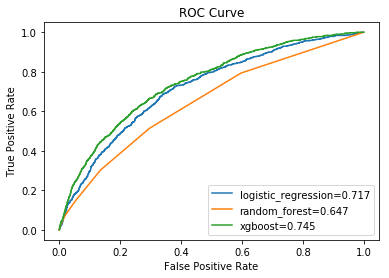

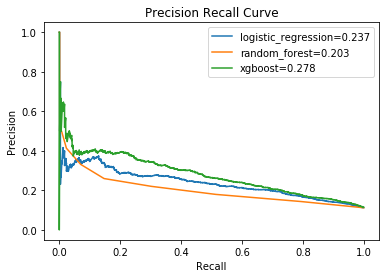

In [90]:
run_pipeline(dimension_reduction=False)